# Rutina de análisis inicial y de resultados de datos etiquetados durante QC a EMA

> Elaborado por Paola Álvarez, profesional contratista IDEAM, contrato 196 de 2024. Comentarios o inquietudes, remitir a *palvarez@ideam.gov.co* 

El análisis de resultados se incluye dentro del documento de diagnóstico de series temporales.
___
**Librerías:**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
import matplotlib.image as mpimg
import glob
import os
import statistics
from matplotlib.ticker import FuncFormatter
from scipy import stats

_____

### Longitud y continuidad series de datos de EMA - Gráficas

In [ ]:
# Path to the directory containing the CSV files
# data_directory = "../OE_3_QC_Variables/3_TemperaturaSuelo/TS10/RawUnmodified_TS10"
data_directory = "../OE_3_QC_Variables/3_TemperaturaSuelo/TS10/QCResult_TS10"
# List to hold dataframes
dataframes = []

# Load each CSV file into a dataframe and add it to the list
for filename in os.listdir(data_directory):
    if filename.endswith(".csv"):
        try:
            df = pd.read_csv(os.path.join(data_directory, filename), parse_dates=['Fecha'], encoding='latin-1')

            # Se verifica si 'Estado' existe y se aplica filtro
            if 'Estado' in df.columns:
                df = df[~df['Estado'].apply(lambda x: any([str(x).startswith(prefix) for prefix in ['0PSO0','0PAT','0PER']]))]

            # Only proceed if the DataFrame is not empty after filtering
            if not df.empty:
                df = df.copy()
                df.set_index('Fecha', inplace=True)
                df['Presence'] = 1  # Add a column to indicate data presence
                dataframes.append(df)
        except Exception as e:
            print(f"Error loading {filename}: {e}")

# Se muestran los headers y fechas por archivo para ver estructura - Para caso de ejemplo
dataframes_info = [(df.head(), df.index.min(), df.index.max()) for df in dataframes]
dataframes_info

In [ ]:
# Esta si
# Ordenar lista de dataframes
dataframes = sorted(dataframes, key=lambda x: x['Station'].iloc[0])

# Se crea el date range con las fechas inicial y final conocidas, para presión atmosférica 01/01/2001 a 03/04/2024, horaria
date_range = pd.date_range(start="2003-02-10 00:00", end="2024-10-15 23:00", freq='h')

# Número de estaciones por gráfico
estaciones_por_grafico = 50

# Total de gráficos a generar
total_graficos = len(dataframes) // estaciones_por_grafico + (len(dataframes) % estaciones_por_grafico > 0)

# Configuración de la fuente para todo el gráfico
font = {'family': 'Franklin Gothic Book',
        'weight': 'normal',
        'size': 10}

plt.rc('font', **font)

for j in range(total_graficos):
    fig, ax = plt.subplots(figsize=(15, 10))
    inicio = j * estaciones_por_grafico
    fin = min(inicio + estaciones_por_grafico, len(dataframes))  # Asegurarse de no pasarse del rango

    # Define a helper function to plot data for clarity
    def plot_station_data(ax, data, index, station_label):
        # Find where data is present
        presence_mask = data['Presence'] == 1
        # Plot only where data is present
        ax.fill_between(data.index, index - 0.45, index + 0.45, where=~presence_mask, color='#f0f0f0', step='mid', label='Sin dato' if i == 1 else "")
        ax.fill_between(data.index, index - 0.45, index + 0.45, where=presence_mask, color='#a04000', step='mid', label='Con dato' if i == 1 else "")

    for i, df in enumerate(dataframes[inicio:fin], start=1):
        # Check for duplicates
        duplicates = df.index.duplicated()
        # Optionally, drop or keep the first/last occurrence of duplicates
        if duplicates.any():
            df = df.loc[~duplicates]
        # Reindex the dataframe to the full date range, filling missing data with 0 (indicating absence)
        df_complete = df.reindex(date_range, fill_value=0)
        plot_station_data(ax, df_complete, i, f"Station {df['Station'].iloc[0]}")

    #ax.legend(loc='upper left')  # Agrega la leyenda en la esquina superior izquierda
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=2)
    # Setting the labels and ticks for better readability
    ax.set_yticks(range(1, fin - inicio + 1))
    ax.set_yticklabels([f"{df['Station'].iloc[0]}" for df in dataframes[inicio:fin]], fontsize=8)
    ax.set_ylim(0.5, fin - inicio + 0.5)
    ax.set_xlim(date_range[0], date_range[-1])
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.xticks(rotation=90)
    plt.ylabel('Código de estación CNE')
    plt.title(f'Completitud de datos por estación - Grupo de estaciones {j+1} de {total_graficos}')
    plt.grid(True, which='both', linestyle='-', linewidth=0.25)

    # Show and save the plot
    plt.tight_layout()
    # Definir la carpeta donde se guardará el gráfico
    output_folder = "Figs_LongyCompletDatos_TS10_qc"  # Cambia esto por la carpeta que quieras
    os.makedirs(output_folder, exist_ok=True)  # Crear la carpeta si no existe
    # Guardar el gráfico en la carpeta especificada
    plt.savefig(os.path.join(output_folder, f'completitud_datos_grafico_{j+1}.png'))  # Guarda el gráfico como un archivo PNG
    plt.close(fig)  # Cierra la figura para liberar memoria

### Cantidad total de datos

In [ ]:
## Se indaga sobre cuál es la cantidad de datos de todas las series descargadas en el período 2001-01-01 al 2024-03-31
# Se crea la función cantidad_datos
def cantidad_datos(archivos):
    total_filas = 0

    for archivo in archivos:
        # Se utiliza el método 'chunksize' de pandas para leer los archivos por partes (chunks)
        # y procesarlos de forma incremental sin cargar todos los datos en memoria al mismo tiempo
        chunks = pd.read_csv(archivo, encoding='latin-1', chunksize=100000)  # Se establece este valor de chunk para poder hacer otras actividades

        for chunk in chunks:
            total_filas += len(chunk)

    return total_filas

# Ruta de la carpeta con los archivos CSV
carpeta_proces = "../OE_3_QC_Variables/3_TemperaturaSuelo/TS10/RawUnmodified_TS10/"

# Obtener la lista de archivos en la carpeta
archivos = [carpeta_proces + archivo for archivo in os.listdir(carpeta_proces) if archivo.endswith('.csv')]

# Llamar a la función para contar las filas
total_filas = cantidad_datos(archivos)

# Imprimir el resultado
print("El número total de datos es:", total_filas)

### Contar datos por fecha

In [ ]:
def contar_datos_por_fechas(archivos):
    resultados = []

    for archivo in archivos:
        chunks = pd.read_csv(archivo, encoding='latin-1', chunksize=100000)
        
        for chunk in chunks:
            chunk['Fecha'] = pd.to_datetime(chunk['Fecha'], format='%Y-%m-%d %H:%M:%S.%f')
            estacion = chunk['Station'].iloc[0]
            
            # Conteo por año, mes y día
            conteo_dia = chunk['Fecha'].dt.to_period('D').value_counts().rename_axis('Año-mes-dia').reset_index(name='Cantidad_año-mes-dia')
            conteo_dia['Año-mes'] = conteo_dia['Año-mes-dia'].dt.to_timestamp().dt.to_period('M')
            conteo_dia['Año'] = conteo_dia['Año-mes'].dt.year

            # Conteo por año y mes
            conteo_mes = chunk['Fecha'].dt.to_period('M').value_counts().rename_axis('Año-mes').reset_index(name='Cantidad_año-mes')
            conteo_mes['Año'] = conteo_mes['Año-mes'].dt.year

            # Conteo por año
            conteo_anual = chunk['Fecha'].dt.year.value_counts().rename_axis('Año').reset_index(name='Cantidad_año')
            
            # Combinar con la información de la estación
            conteo_anual['Station'] = estacion
            conteo_mes['Station'] = estacion
            conteo_dia['Station'] = estacion
            
            # Merge considerando Station, Año y Año-mes
            merged_data = pd.merge(pd.merge(conteo_anual, conteo_mes, on=['Station', 'Año']), conteo_dia, on=['Station', 'Año', 'Año-mes'])
            resultados.append(merged_data)
    
    df_resultados = pd.concat(resultados, ignore_index=True)
    # Reordenar columnas
    df_resultados = df_resultados[['Station', 'Año', 'Cantidad_año', 'Año-mes', 'Cantidad_año-mes','Año-mes-dia','Cantidad_año-mes-dia']]
    df_resultados.sort_values(by=['Station', 'Año', 'Año-mes', 'Año-mes-dia'], inplace=True)
    
    # Rellenar la columna 'Cantidad_año' sólo una vez por cada año y estación
    df_resultados['Cantidad_año'] = df_resultados.groupby(['Station', 'Año'])['Cantidad_año'].transform(lambda x: x.iloc[0] if not x.isna().all() else pd.NA)
    
    df_resultados.to_csv('ConteoDatos_AnioMesDia_TS10.csv', index=False, encoding='latin-1')
    return df_resultados

# Uso de la función
carpeta_proces = "../OE_3_QC_Variables/3_TemperaturaSuelo/TS10/RawUnmodified_TS10/"
archivos = [carpeta_proces + archivo for archivo in os.listdir(carpeta_proces) if archivo.endswith('.csv')]
resultados = contar_datos_por_fechas(archivos)
print(resultados.head())

In [45]:
### Lectura de frecuencias para revisión inicial
dffreq = pd.read_csv('ConteoDatos_AnioMesDia_TS10.csv', encoding='latin-1')
dffreq.head(2)

,Station,Año,Cantidad_año,Año-mes,Cantidad_año-mes,Año-mes-dia,Cantidad_año-mes-dia
0,11105020,2005,7258,2005-04,600,2005-04-05,1
1,11105020,2005,7258,2005-04,600,2005-04-06,24


In [47]:
# Se agrupa por 'Station' y se suma la columna respectiva
sttn_qtty = dffreq.groupby('Station')['Cantidad_año-mes-dia'].sum().reset_index()

# Se renombra la columna
sttn_qtty.rename(columns={'Cantidad_año-mes-dia': 'CantDatos'}, inplace=True)

In [49]:
sttn_qtty.to_csv('CantDatosPorEstacion_TS10.csv', encoding='latin-1', index=True, sep=';')

### Obtener fechas iniciales y finales de estaciones

In [ ]:
def obtener_fechas(archivo):
    try:
        # Se lee el archivo
        datos = pd.read_csv(archivo, encoding='latin-1')#, names=['Fecha', 'Valor'])
        try:
            datos['Fecha'] = pd.to_datetime(datos['Fecha'], format='%Y-%m-%d %H:%M:%S.%f')
        except ValueError:
            datos['Fecha'] = pd.to_datetime(datos['Fecha'], format='%Y-%m-%d %H:%M:%S')
        
        # Se obtiene el código de la estación
        station = datos['Station'].values[0]
        
        # Se obtiene primera y última fecha 
        fecha_inicial = datos['Fecha'].iloc[0]
        fecha_final = datos['Fecha'].iloc[-1]
        
        return station, fecha_inicial, fecha_final
    
    except Exception as e:
        print(f"Error con el archivo {archivo}: {e}")
        return None, None, None

def main():
    # Cambia la ruta según la ubicación de tu carpeta
    ruta_carpeta = "../OE_3_QC_Variables/3_TemperaturaSuelo/TS10/RawUnmodified_TS10/"

    # Listamos todos los archivos en la carpeta que terminen con .csv
    archivos = [f for f in os.listdir(ruta_carpeta) if f.endswith('.csv')]
    
    # Creamos una lista para almacenar los resultados
    resultados = []

    # Iteramos sobre cada archivo y obtenemos las fechas
    for archivo in archivos:
        ruta_archivo = os.path.join(ruta_carpeta, archivo)
        station, fecha_inicial, fecha_final = obtener_fechas(ruta_archivo)
        
        if station and fecha_inicial and fecha_final:
            resultados.append([station, fecha_inicial, fecha_final])
    
    # Convertimos los resultados a un DataFrame
    resultados_df = pd.DataFrame(resultados, columns=['CodEstacion', 'fecha_inicial', 'fecha_final'])
    
    # Guardamos el DataFrame como un archivo CSV
    resultados_df.to_csv('FechaInicialFinal_TS10.csv', index=False)

if __name__ == "__main__":
    main()

### Obtener estadísticos descriptivos

In [ ]:
def obtener_EstadDescript(archivo):
    try:
        # Se lee el archivo
        datos = pd.read_csv(archivo, encoding='latin-1')#, names=['Fecha', 'Valor'])
        try:
            datos['Fecha'] = pd.to_datetime(datos['Fecha'], format='%Y-%m-%d %H:%M:%S.%f')
        except ValueError:
            datos['Fecha'] = pd.to_datetime(datos['Fecha'], format='%Y-%m-%d %H:%M:%S')
        
        # Se obtiene el código de la estación
        station = datos['Station'].values[0]
        
        # Se obtienen los estadísticos descriptivos
        minimo = datos['Valor'].min()
        maximo = datos['Valor'].max()
        media = datos['Valor'].mean()
        mediana = datos['Valor'].median()
        desvest = datos['Valor'].std()
        varianza = datos['Valor'].var()
        #first_q = datos['Valor'].quantile(0.25)
        #third_q = datos['Valor'].quantile(0.75)
        
        return station, minimo, maximo, media, mediana, desvest, varianza, #first_q, third_q, mediana --no fue posible calcular estos estad.
    
    except Exception as e:
        print(f"Error con el archivo {archivo}: {e}")
        print(e.__class__)
        return None, None, None, None, None, None, None#, None, None --no fue posible calcular estos estad.

def main():
    # Cambia la ruta según la ubicación de tu carpeta
    ruta_carpeta = "../OE_3_QC_Variables/3_TemperaturaSuelo/TS10/RawUnmodified_TS10/"

    # Listamos todos los archivos en la carpeta que terminen con .csv
    archivos = [f for f in os.listdir(ruta_carpeta) if f.endswith('.csv')]
    
    # Se crea una lista para almacenar los resultados
    resultados = []

    # Se itera sobre cada archivo y se obtienen fechas las fechas
    for archivo in archivos:
        ruta_archivo = os.path.join(ruta_carpeta, archivo)
        station, minimo, maximo, media, mediana, desvest, varianza= obtener_EstadDescript(ruta_archivo)
        print(station, minimo, maximo, media, mediana, desvest, varianza)
        resultados.append([station, minimo, maximo, media, mediana, desvest, varianza])
        #if station and minimo: #and maximo and media and mediana and desvest and varianza:
            #resultados.append([station, minimo, maximo, media, mediana, desvest, varianza])
        #else:
            #print(f'Sin suficientes resultado para {archivo}. No se generaron sus estadísticos')
    
    # Se convierten los resultados a un DataFrame
    resultados_df = pd.DataFrame(resultados, columns=['Station', 'minimo', 'maximo', 'media', 'mediana','desvest', 'varianza'])
    
    print(resultados_df)
    
    # Se guarda el DataFrame como un archivo CSV
    resultados_df.to_csv('EstadDescript_TS10_Raw.csv', index=False)

if __name__ == "__main__":
    main()

In [ ]:
resultados_df = pd.read_csv('EstadDescript_TS10_Raw.csv')

In [ ]:
altipatm = pd.read_table('EMA_Patm_TMaxMin.txt', sep=';')

In [ ]:
altipatm.head(2)

In [ ]:
estadalt = pd.merge(resultados_df, altipatm[['Station','Altitud']], on='Station')

In [ ]:
# Se sobreescriben los estadísticos para incluir altitud
estadalt.to_csv('EstadDescript_Patm_Raw.csv', index=False)

In [17]:
# De datos con QC
def obtener_EstadDescript(archivo):
    try:
        # Se lee el archivo
        datos = pd.read_csv(archivo, encoding='latin-1')#, names=['Fecha', 'Valor'])
        try:
            datos['Fecha'] = pd.to_datetime(datos['Fecha'], format='%Y-%m-%d %H:%M:%S.%f')
        except ValueError:
            datos['Fecha'] = pd.to_datetime(datos['Fecha'], format='%Y-%m-%d %H:%M:%S')
        
        # Se hace el filtro para que solo queden los valores que superaron las pruebas
        dfC = datos[datos['Estado'].apply(lambda x: any([str(x).startswith(prefix) for prefix in ['0PC']]))]
        
        # Se obtiene el código de la estación
        station = dfC['Station'].values[0]
        
        # Se obtienen los estadísticos descriptivos
        minimo = dfC['Valor'].min()
        maximo = dfC['Valor'].max()
        media = dfC['Valor'].mean()
        #mediana = datos['Valor'].median()
        desvest = dfC['Valor'].std()
        varianza = dfC['Valor'].var()
        #first_q = datos['Valor'].quantile(0.25)
        #third_q = datos['Valor'].quantile(0.75)
        
        return station, minimo, maximo, media, desvest, varianza, #first_q, third_q, mediana --no fue posible calcular estos estad.
    
    except Exception as e:
        print(f"Error con el archivo {archivo}: {e}")
        print(e.__class__)
        return None, None, None, None, None, None#, None, None, None --no fue posible calcular estos estad.

def main():
    # Cambia la ruta según la ubicación de tu carpeta
    ruta_carpeta = '../OE_3_QC_Variables/3_TemperaturaSuelo/TS10/QCResult_TS10'

    # Listamos todos los archivos en la carpeta que terminen con .csv
    archivos = [f for f in os.listdir(ruta_carpeta) if f.endswith('.csv')]
    
    # Creamos una lista para almacenar los resultados
    resultados = []

    # Iteramos sobre cada archivo y obtenemos las fechas
    for archivo in archivos:
        ruta_archivo = os.path.join(ruta_carpeta, archivo)
        station, minimo, maximo, media, desvest, varianza= obtener_EstadDescript(ruta_archivo)
        
        if station and minimo and maximo and media and desvest and varianza:
            resultados.append([station, minimo, maximo, media, desvest, varianza])
    
    # Convertimos los resultados a un DataFrame
    resultados_df = pd.DataFrame(resultados, columns=['Station', 'minimo', 'maximo', 'media', 'desvest', 'varianza'])
    
    # Guardamos el DataFrame como un archivo CSV
    resultados_df.to_csv('EstadDescript_TS10_qc.csv', index=False)

if __name__ == "__main__":
    main()

Error con el archivo ../OE_3_QC_Variables/3_TemperaturaSuelo/TS10/QCResult_TS10\Estacion_0011105020_qc.csv: index 0 is out of bounds for axis 0 with size 0
<class 'IndexError'>
Error con el archivo ../OE_3_QC_Variables/3_TemperaturaSuelo/TS10/QCResult_TS10\Estacion_0011135030_qc.csv: index 0 is out of bounds for axis 0 with size 0
<class 'IndexError'>
Error con el archivo ../OE_3_QC_Variables/3_TemperaturaSuelo/TS10/QCResult_TS10\Estacion_0012015100_qc.csv: index 0 is out of bounds for axis 0 with size 0
<class 'IndexError'>
Error con el archivo ../OE_3_QC_Variables/3_TemperaturaSuelo/TS10/QCResult_TS10\Estacion_0012015110_qc.csv: index 0 is out of bounds for axis 0 with size 0
<class 'IndexError'>
Error con el archivo ../OE_3_QC_Variables/3_TemperaturaSuelo/TS10/QCResult_TS10\Estacion_0013085050_qc.csv: index 0 is out of bounds for axis 0 with size 0
<class 'IndexError'>
Error con el archivo ../OE_3_QC_Variables/3_TemperaturaSuelo/TS10/QCResult_TS10\Estacion_0015075150_qc.csv: index 0

C:\Users\palvarez\AppData\Local\Temp\ipykernel_31628\3357405747.py:5: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  datos = pd.read_csv(archivo, encoding='latin-1')#, names=['Fecha', 'Valor'])


Error con el archivo ../OE_3_QC_Variables/3_TemperaturaSuelo/TS10/QCResult_TS10\Estacion_0021202270_qc.csv: index 0 is out of bounds for axis 0 with size 0
<class 'IndexError'>
Error con el archivo ../OE_3_QC_Variables/3_TemperaturaSuelo/TS10/QCResult_TS10\Estacion_0021206930_qc.csv: index 0 is out of bounds for axis 0 with size 0
<class 'IndexError'>
Error con el archivo ../OE_3_QC_Variables/3_TemperaturaSuelo/TS10/QCResult_TS10\Estacion_0021206950_qc.csv: index 0 is out of bounds for axis 0 with size 0
<class 'IndexError'>
Error con el archivo ../OE_3_QC_Variables/3_TemperaturaSuelo/TS10/QCResult_TS10\Estacion_0021206990_qc.csv: index 0 is out of bounds for axis 0 with size 0
<class 'IndexError'>
Error con el archivo ../OE_3_QC_Variables/3_TemperaturaSuelo/TS10/QCResult_TS10\Estacion_0021215150_qc.csv: index 0 is out of bounds for axis 0 with size 0
<class 'IndexError'>
Error con el archivo ../OE_3_QC_Variables/3_TemperaturaSuelo/TS10/QCResult_TS10\Estacion_0021255160_qc.csv: index 0

C:\Users\palvarez\AppData\Local\Temp\ipykernel_31628\3357405747.py:5: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  datos = pd.read_csv(archivo, encoding='latin-1')#, names=['Fecha', 'Valor'])


Error con el archivo ../OE_3_QC_Variables/3_TemperaturaSuelo/TS10/QCResult_TS10\Estacion_0052055210_qc.csv: index 0 is out of bounds for axis 0 with size 0
<class 'IndexError'>
Error con el archivo ../OE_3_QC_Variables/3_TemperaturaSuelo/TS10/QCResult_TS10\Estacion_0052055220_qc.csv: index 0 is out of bounds for axis 0 with size 0
<class 'IndexError'>
Error con el archivo ../OE_3_QC_Variables/3_TemperaturaSuelo/TS10/QCResult_TS10\Estacion_0053075020_qc.csv: index 0 is out of bounds for axis 0 with size 0
<class 'IndexError'>
Error con el archivo ../OE_3_QC_Variables/3_TemperaturaSuelo/TS10/QCResult_TS10\Estacion_0055015010_qc.csv: index 0 is out of bounds for axis 0 with size 0
<class 'IndexError'>
Error con el archivo ../OE_3_QC_Variables/3_TemperaturaSuelo/TS10/QCResult_TS10\Estacion_0057025020_qc.csv: index 0 is out of bounds for axis 0 with size 0
<class 'IndexError'>
Error con el archivo ../OE_3_QC_Variables/3_TemperaturaSuelo/TS10/QCResult_TS10\Estacion_3526500201_qc.csv: index 0

_____

## Cantidad de datos abanderados al aplicar QC automatizados

In [21]:
## Cantidad y porcentaje de datos abanderados por estación
def generar_dataframe_compilado(archivos):
    datos = []

    for archivo in archivos:
        # Leer el archivo CSV en modo iterador y especificar los tipos de datos
        reader = pd.read_csv(archivo, iterator=True, dtype={'station': str, 'state': str, 'prev_state':str}, chunksize=70000, 
                             encoding='latin-1')

        # Inicializar contador de filas y contador de '0P'
        total_filas = 0
        cantidad_0PSO = 0
        cantidad_0PER = 0
        cantidad_0PAT = 0
        cantidad_0PCO = 0

        # Obtener los chunks de datos del archivo
        for chunk in reader:
            total_filas += len(chunk)
            cantidad_0PSO +=  chunk[chunk['state'].str.startswith('0PSO', na=False)].shape[0]
            cantidad_0PER +=  chunk[chunk['state'].str.startswith('0PER', na=False)].shape[0]
            cantidad_0PAT +=  chunk[chunk['state'].str.startswith('0PAT', na=False)].shape[0]
            cantidad_0PCO += chunk[chunk['state'].str.startswith('0PCO', na=False)].shape[0]

        cantidad_0P = cantidad_0PSO + cantidad_0PER + cantidad_0PAT
        
        # Obtener el 'Station' respectivo
        station = chunk['station'].iloc[0]
        
        # Obtener porcentajes
        perc_0PSO = round((cantidad_0PSO/total_filas*100),2)
        perc_0PER = round((cantidad_0PER/total_filas*100),2)
        perc_0PAT = round((cantidad_0PAT/total_filas*100),2)
        perc_0P = round((cantidad_0P/total_filas*100),2)
        perc_0PCO = round((cantidad_0PCO/total_filas*100),2)

        # Agregar los datos a la lista
        datos.append({'Estacion': station, 'TotalDatos': total_filas, 'Estado_0PER': cantidad_0PER,
                      'Estado_0PAT': cantidad_0PAT, 'Estado_0PSO': cantidad_0PSO, 'Estado_0PCO': cantidad_0PCO, 'Estado_0P': cantidad_0P,
                      'Per_0PER': perc_0PER, 'Per_0PAT': perc_0PAT, 'Per_0PSO': perc_0PSO, 'Per_0P': perc_0P, 'Per_0PCO': perc_0PCO})
        #print(datos)

    # Crear el nuevo DataFrame compilado
    df_compilado = pd.DataFrame(datos)

    return df_compilado

# Ruta de la carpeta con los archivos CSV
carpeta = '../OE_3_QC_Variables/3_TemperaturaSuelo/TS10/ReadyToCassandraFiles_TS10/TS10_AUT/'

# Obtener la lista de archivos en la carpeta
archivos = [carpeta + archivo for archivo in os.listdir(carpeta) if archivo.endswith('.csv')]

# Llamar a la función para generar el nuevo DataFrame compilado
df_compilado = generar_dataframe_compilado(archivos)

# Imprimir el nuevo DataFrame
print(df_compilado)

# Exportar el df compilado
df_compilado.to_csv('CantBanderas_QCResult_TS10.csv', index=False)

      Estacion  TotalDatos  Estado_0PER  Estado_0PAT  Estado_0PSO  \
0     11105020       59572        14965         1915        19774   
1     11135030       53423           12         4092         3441   
2     12015100       66795          706         4018         5277   
3     12015110       57419           90         4159         1418   
4     13085050       38123          255         2096         4179   
..         ...         ...          ...          ...          ...   
81    52055220      115001          398         6009         9570   
82    53075020       59980            4         3540          574   
83    55015010       40286            4         2694         4102   
84    57025020       74443          922         4322         6641   
85  3526500201       20353           30          770          162   

    Estado_0PCO  Estado_0P  Per_0PER  Per_0PAT  Per_0PSO  Per_0P  Per_0PCO  
0         22918      36654     25.12      3.21     33.19   61.53     38.47  
1         45878  

In [31]:
## Cantidad y porcentaje de datos abanderados por entidad
def generar_dataframe_compilado(archivos):
    datos = []

    for archivo in archivos:
        # Leer el archivo CSV en modo iterador y especificar los tipos de datos
        reader = pd.read_csv(archivo, iterator=True, dtype={'station': str, 'state': str,'prev_state':str}, chunksize=70000, 
                             encoding='latin-1')

        # Inicializar contador de filas y contador de '0P'
        total_filas = 0
        cantidad_0PSO = 0
        cantidad_0PER = 0
        cantidad_0PAT = 0
        cantidad_0PCO = 0

        # Obtener los chunks de datos del archivo
        for chunk in reader:
            total_filas += len(chunk)
            cantidad_0PSO +=  chunk[chunk['state'].str.startswith('0PSO', na=False)].shape[0]
            cantidad_0PER +=  chunk[chunk['state'].str.startswith('0PER', na=False)].shape[0]
            cantidad_0PAT +=  chunk[chunk['state'].str.startswith('0PAT', na=False)].shape[0]
            cantidad_0PCO += chunk[chunk['state'].str.startswith('0PCO', na=False)].shape[0]

        cantidad_0P = cantidad_0PSO + cantidad_0PER + cantidad_0PAT

        cantidad_0P = cantidad_0PSO + cantidad_0PER + cantidad_0PAT
        
        # Obtener el 'Station' respectivo
        station = chunk['station'].iloc[0]
        
        # Obtener porcentajes
        perc_0PSO = round((cantidad_0PSO/total_filas*100),2)
        perc_0PER = round((cantidad_0PER/total_filas*100),2)
        perc_0PAT = round((cantidad_0PAT/total_filas*100),2)
        perc_0P = round((cantidad_0P/total_filas*100),2)
        perc_0PCO = round((cantidad_0PCO/total_filas*100),2)

        # Agregar los datos a la lista
        datos.append({'station': station, 'TotalDatos': total_filas, 'Estado_0PER': cantidad_0PER,
                      'Estado_0PAT': cantidad_0PAT, 'Estado_0PSO': cantidad_0PSO, 'Estado_0PCO': cantidad_0PCO, 'Estado_0P': cantidad_0P,
                      'Per_0PER': perc_0PER, 'Per_0PAT': perc_0PAT, 'Per_0PSO': perc_0PSO, 'Per_0P': perc_0P, 'Per_0PCO': perc_0PCO})

    # Crear el nuevo DataFrame compilado
    df_compilado = pd.DataFrame(datos)
    # Convertir la columna 'Station' a tipo 'int64'
    df_compilado['station'] = df_compilado['station'].astype('int64')

    # Cargar el archivo 'EMA_AllInfo.txt'
    ema_all = pd.read_csv('../OE_3_QC_Variables/3_TemperaturaSuelo/TS10/EMATS10_LatLonEntFreq.csv', encoding='latin-1') #sep=';',
    
    # Convertir la columna 'Station' a tipo 'str'
    ema_all['station'] = ema_all['station'].astype('int64')
    
    # Unir los dataframes para agregar la columna 'project'
    df_compilado = pd.merge(df_compilado, ema_all[['station', 'entidad']], on='station', how='left')

    # Agrupar por proyecto y obtener los resultados deseados
    resultado = df_compilado.groupby('entidad').agg({
        'TotalDatos': 'sum',
        'Estado_0PSO': 'sum',
        'Estado_0PAT': 'sum',
        'Estado_0PER': 'sum',
        'Estado_0P': 'sum',
        'Estado_0PCO': 'sum',
        'Per_0PSO': 'mean',
        'Per_0PAT': 'mean',
        'Per_0PER': 'mean',
        'Per_0P': 'mean',
        'Per_0PCO': 'mean',
    }).reset_index()

    return resultado

# Ruta de la carpeta con los archivos CSV
carpeta = '../OE_3_QC_Variables/3_TemperaturaSuelo/TS10/ReadyToCassandraFiles_TS10/TS10_AUT/'

# Obtener la lista de archivos en la carpeta
archivos = [carpeta + archivo for archivo in os.listdir(carpeta) if archivo.endswith('.csv')]

# Llamar a la función para generar el nuevo DataFrame compilado
df_compilado = generar_dataframe_compilado(archivos)

# Imprimir el nuevo DataFrame
print(df_compilado)

# Exportar el df compilado
df_compilado.to_csv('CantBanderas_QCResult_TS10_entidad.csv', index=False)

  entidad  TotalDatos  Estado_0PSO  Estado_0PAT  Estado_0PER  Estado_0P  \
0   IDEAM     6047159       308723       286272       218494     813489   

   Estado_0PCO  Per_0PSO  Per_0PAT  Per_0PER     Per_0P   Per_0PCO  
0      5233670  6.470706  8.457059  4.878588  19.805412  80.194588  


In [5]:
## Se genera rutina para analizar los porcentajes obtenidos de datos etiquetados
dfflag = pd.read_csv('CantBanderas_QCResult_TS10.csv')
dfflag.head(2)

,Estacion,TotalDatos,Estado_0PER,Estado_0PAT,Estado_0PSO,Estado_0PCO,Estado_0P,Per_0PER,Per_0PAT,Per_0PSO,Per_0P,Per_0PCO
0,11105020,59572,14965,1915,19774,22918,36654,25.12,3.21,33.19,61.53,38.47
1,11135030,53423,12,4092,3441,45878,7545,0.02,7.66,6.44,14.12,85.88


RangPerc0P
5-9 %      28
10-14 %    22
15-19 %    12
0-4 %       6
100 %       3
20-24 %     3
25-29 %     2
30-34 %     2
35-39 %     1
40-44 %     1
55-59 %     1
60-64 %     1
65-69 %     1
70-74 %     1
85-89 %     1
95-99 %     1
45-49 %     0
75-79 %     0
80-84 %     0
90-94 %     0
50-54 %     0
Name: count, dtype: int64


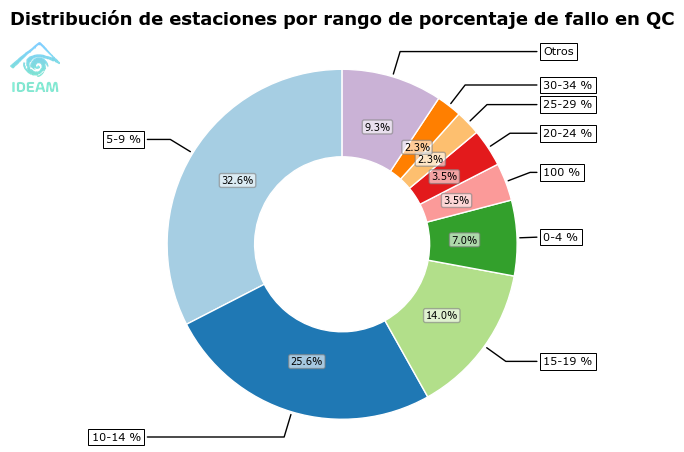

In [7]:
## Generar gráfico por rango de porcentajes obtenidos de 'QC'
# Opción de rangos de 5 en 5
en5 = range(0, 106, 5)  # Rango de bins
n5 = list(en5)
bins = n5
labels = [f'{i}-{i + 4} %' for i in range(0, 100, 5)] + ['100 %']
dfflag['RangPerc0P'] = pd.cut(dfflag['Per_0P'], bins=bins, labels=labels, right=False)
sizes = dfflag['RangPerc0P'].value_counts()
print(sizes)

# Convirtiendo a DataFrame para mejor manejo
df = pd.DataFrame({'Rangos': labels, 'Valores': sizes})

# Calcula el total y el umbral
total = df['Valores'].sum()
threshold = 0.015  # 1%
total = sizes.sum()

# Filtrar aquellos que cumplen con el umbral
mask = sizes/total >= threshold

# Las categorías y valores que cumplen con el umbral
filtered_labels = sizes.index[mask].tolist()
filtered_values = sizes.values[mask].tolist()

# La suma de las categorías que NO cumplen con el umbral
remaining_sum = sizes[~mask].sum()

# Añadir la categoría 'Otros' si hay valores que cumplen el umbral
if remaining_sum > 0:
    filtered_labels.append('Otros')
    filtered_values.append(remaining_sum)

# Colores
colors = plt.cm.Paired(range(len(filtered_labels)))

# Gráfico de torta
fig, ax = plt.subplots(figsize=(8, 5))
wedges, texts, autotexts = ax.pie(filtered_values, labels=None, colors=colors, autopct='%1.1f%%', pctdistance=0.7,
                                  startangle=90, wedgeprops=dict(width=0.5, edgecolor='white'))

# Modificar el estilo de los porcentajes
for autotext in autotexts:
    autotext.set_fontname('Verdana')
    autotext.set_fontsize(7)
    autotext.set_fontstretch('condensed')
    autotext.set_bbox(dict(facecolor='white', alpha=0.6, edgecolor='gray', boxstyle='round,pad=0.2'))

# Estilo para las etiquetas
bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

# Colocar etiquetas con líneas
for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = f"angle,angleA=0,angleB={ang}"
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(filtered_labels[i], xy=(x, y), xytext=(1.15*np.sign(x), 1.15*y),
                horizontalalignment=horizontalalignment, fontname='Verdana', fontsize=8, fontstretch='condensed', **kw)

# Título y formato
plt.title('Distribución de estaciones por rango de porcentaje de fallo en QC', fontname='Verdana', fontstretch='condensed', 
          fontsize=13, fontweight='bold', y=1.05)
ax.axis('equal')  # Igualar la relación de aspecto para que la torta sea circular

# Cargar el logo IDEAM
logo = mpimg.imread('Logo_IDEAM_Color2.png')

# Agregar el logo en la esquina superior izquierda
newax = fig.add_axes([0.04, 0.8, 0.12, 0.1], anchor='NE', zorder=1)
newax.imshow(logo, alpha=0.5) 
newax.axis('off')

plt.savefig(f'FalloQC_porcEstaciones_TS10.png')
plt.show()

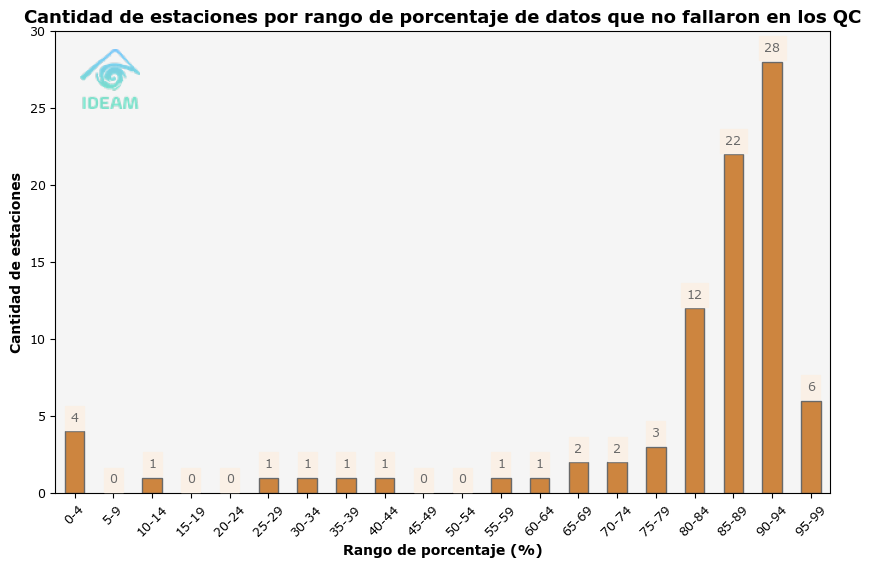

In [9]:
# Generar gráfico por rango de porcentajes obtenidos de '0PC0'
# Opción de rangos de 5 en 5
en5 = range(0, 106, 5)  # Rango de bins
n5 = list(en5)
bins = n5
labels = [f'{i}-{i + 4}' for i in range(0, 100, 5)] + ['100']
dfflag['RangPerc'] = pd.cut(dfflag['Per_0PCO'], bins=bins, labels=labels, right=False)


# Crear el gráfico
fig = plt.figure(figsize=(10,6))
ax = dfflag['RangPerc'].value_counts(sort=False).iloc[:-1].plot(kind='bar', color='peru', edgecolor='dimgray')
plt.xlabel('Rango de porcentaje (%)', fontname='Verdana', fontsize=10, fontweight='bold', fontstretch='condensed')
plt.ylabel('Cantidad de estaciones', fontname='Verdana', fontsize=10, fontweight='bold', fontstretch='condensed')
plt.title('Cantidad de estaciones por rango de porcentaje de datos que no fallaron en los QC', fontname='Verdana', 
          fontsize=13, fontweight='bold', fontstretch='condensed')
plt.xticks(fontname='Verdana', fontsize=9, fontstretch='condensed', rotation=45) # si de 5 en 5 rotation=45
plt.yticks(fontname='Verdana', fontsize=9, fontstretch='condensed')
plt.ylim(0,30)
ax.set_facecolor('whitesmoke')
#plt.grid(axis='y', linestyle='-', alpha=0.7, color='gainsboro')

color = mcolors.to_rgba('linen')#, alpha=0.3)
# Añadir etiquetas de datos
ax.bar_label(ax.containers[0], label_type='edge', padding=5, fontname='Verdana', fontsize=9, color='dimgray', 
             backgroundcolor=color)

# Cargar el logo IDEAM
logo = mpimg.imread('Logo_IDEAM_Color2.png')

# Agregar el logo en la esquina superior izquierda
newax = fig.add_axes([0.01, 0.75, 0.2, 0.1], anchor='NE', zorder=1)
newax.imshow(logo, alpha=0.5) 
newax.axis('off')

plt.savefig(f'CorrectoQC_cantEstaciones_TS10.png')
plt.show()